# Importing all the Dependencies

In [1]:
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import prawcore
import numpy as np
import praw
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize , word_tokenize
import json
import os
import csv
import glob
import datetime
from prawcore.exceptions import RequestException
import time

## Setting up PushShift and PRAW API for Reddit Data Extraction


In [ ]:
# Set up Pushshift API URL
base_url = 'https://api.pushshift.io/reddit/search/submission/'

# Define function to get data from Pushshift API
def get_data_from_pushshift(subreddit, start_date, end_date,date_range):
    data = []
    while start_date < end_date:
        url = f'{base_url}?subreddit={subreddit}&after={int(start_date.timestamp())}&before={int((start_date+date_range).timestamp())}&size=1000'
        response = requests.get(url)
        if response.status_code == 200:
            data += response.json()['data']
        start_date += date_range
    return data

#Keyword filter function to extract the data "Politics","Worldnews" subreddits.
def filter_by_keywords(data, keywords):
    filtered_data = []
    for post in data:
        title = post['title'].lower()
        if any(keyword in title for keyword in keywords):
            filtered_data.append(post)
    return filtered_data

#PRAW using Reddit in-built API but please change the below values to correct app values created in Reddit
reddit=praw.Reddit(client_id='pidDk-8ubfgBHgf0JKvflw',
                   client_secret='q0Bnm2TgVYfdDKk4YPMf3BnBh_kkIg',
                   user_agent='u/changeit')



# Setting up the Date Range , Subreddits for Reddit data and Keyword filters. 

If any errors occured while running the below extraction code, it may be due to reddit stopping the Pushshift API's access to Reddits API. or the Credential provided for PRAW needed to be updates correctly as per the secret id and key provided when you created an app on reddit. Above given secret key and client id will work if the correct useragent value is provided or accurate keys must be generated by creating an APP in https://www.reddit.com/prefs/apps, Create an app and use the keys generated in the above section.

If the issue is related to Pushshift you will not receive any data into the posts and will get 400 error. 

In [ ]:
# Set up date range
#Date range given is for 2016 reddit post extract. The other date ranges are mentioned in the report.

start_date = datetime.datetime(2016, 12, 1)
end_date = datetime.datetime(2016, 12, 31)
date_range = datetime.timedelta(days=1)

#Eventhough politics and worldnews are not the dedicated subreddits to climate change, there is always discussion regarding it happening overthere.
# Loop through subreddits and save data to JSON files

#TO-DO Due to limitations with reddit extract may stop in between if there are large number of posts so run with a single subreddit at a time.

subreddits = ['climate','climatepolicy','politics', 'worldnews','environment', 'sustainability','globalwarming','climatechange']

#As the subreddits "","" are of different topics and not dedicated climate change subreddits used below keywords to filter the posts in those subreddits.
# Loop through subreddits and save data to JSON files

keywords = ['climate change', 'global warming','Carbon emissions','Sustainability',
            'Climate policy','Climate action','Paris Agreement','Carbon footprint',
            'Greenhouse gas emissions','Climate adaptation','Renewable energy policies',
            'Fossil fuels','Climate justice','Environmental activism']

# Reddit posts and comment extraction

In [ ]:
#Extracting the Reddit posts using PUSHSHIFT API
for subreddit in subreddits:
    if subreddit in ['politics', 'worldnews']:
        data = get_data_from_pushshift(subreddit, start_date, end_date,date_range)
        data = filter_by_keywords(data, keywords)
    else:
        data = get_data_from_pushshift(subreddit, start_date, end_date,date_range)
    filename = f'{subreddit}_{start_date.date()}_{end_date.date()}.json'
    with open(filename, 'w') as f:
        json.dump(data, f)
posts = []
for submission in data:
    if 'selftext' in submission and submission['selftext'] != '':
        post = {
            'title': submission['title'],
            'text': submission['selftext'],
            'Date_created':datetime.datetime.fromtimestamp(submission["created_utc"]),
            'id':submission["id"],
            'author':submission['author'],
            'subreddit':submission['subreddit'],
            'num_comments':submission['num_comments']
        }
        posts.append(post)
    else:
        post = {
            'title': submission['title'],
            'text': "None",
            'Date_created':datetime.datetime.fromtimestamp(submission["created_utc"]),
            'id':submission["id"],
            'author':submission['author'],
            'subreddit':submission['subreddit'],
            'num_comments':submission['num_comments']
        }
        posts.append(post)
  
#Storing the extracted posts in Pandas Dataframe        
df_initial=pd.DataFrame(posts,columns=['title','text','Date_created','id','author','subreddit','num_comments'])

#Extracting the Reddit Comments based in the Post_id using the PRAW API

def extract_comments(row):
    try:
        submission = reddit.submission(id=row['id'])
        submission.comments.replace_more(limit=None)
        comments = []
        for comment in submission.comments.list():
            author_name = comment.author.name if comment.author else 'None'  
            subreddit_display_name = comment.subreddit.display_name if comment.subreddit else 'None'  

            comment_data = {
                'body': comment.body,
                'Date_created': comment.created_utc,
                'author': author_name,
                'subreddit': subreddit_display_name,
                'post_id': comment.link_id
            }
            comments.append(comment_data)
        return comments
    except prawcore.exceptions.Forbidden as e:
        #no_id=[]
        #no_id.append({row['id']})
        #print(f"Error occurred while extracting comments for post {row['id']}: {e}")
        # Implement rate limit handling
        count=0
        if hasattr(e.response, 'headers'):
            reset_timestamp = int(e.response.headers.get('x-ratelimit-reset'))
            current_timestamp = time.time()
            sleep_time = max(reset_timestamp - current_timestamp, 0) + 1
            count=count+1
            print(count)
            time.sleep(sleep_time)
        return np.nan

comments = []
for _, row in df_initial.iterrows():
    extracted_comments = extract_comments(row)
    if isinstance(extracted_comments, list):
        comments.extend(extracted_comments)

#Create a seperate comment dataframe and filter
df_comments=pd.DataFrame(comments)
df_comments['post_id'] = df_comments['post_id'].str.replace('t3_', '')
df_2=df_initial.copy()
# Check if the "text" column contains 'None', '[deleted]', or '[removed]'
mask = (df_2['text'] == 'None') | (df_2['text'] == '[deleted]') | (df_2['text'] == '[removed]')

# Update the "body" column based on the condition.
df_2['body'] = np.where(mask, df_2['title'], df_2['title'] + ' ' + df_2['text'])
df_filtered= df_2.loc[:, ["body", "Date_created", "author", "subreddit", "id"]]
df_filtered.rename(columns={'id': 'post_id'}, inplace=True)
#Combining the Comments and Posts
df_final=pd.concat([df_comments,df_filtered])
df_final=df_final.reset_index(drop=True)


#Store the comment extracted subreddit wise in a csv file
df_final.to_csv("2016_comment_extracted.csv")



# Sentiment Analysis using VADER

In [1]:
def sentiment_analyzer_score(text):
    
    sentences = sent_tokenize(text)  # Tokenize at the sentence level
    tokenized_sentences = []
    if len(sentences) <=2:
        analyzer=SentimentIntensityAnalyzer()
        scores=[]
        score = analyzer.polarity_scores(text)
        compound_values = score['compound']
        #Scoring based on overall compund score
        if compound_values > 0.05:
            return ("Positive")
        elif compound_values < -0.05:
            return ("Negative")
        else:
            return ("Neutral")
        
    else:
        analyzer=SentimentIntensityAnalyzer()
        scores=[]
        for sentence in sentences:
            score = analyzer.polarity_scores(sentence)
            scores.append(score)
        compound_values = [item['compound'] for item in scores]
        #Scoring based on no.of positive,negative,neutral sentences
        pos=0
        neg=0
        neu=0
        for sc in compound_values:
            if sc > 0.05:
                pos=pos+1
            elif sc < -0.05:
                neg=neg+1
            else:
                neu=neu+1
        label = get_sentiment_label(pos, neg, neu)
        return label
        

def get_sentiment_label(pos, neg, neu):
    if pos > neg and pos > neu:
        return ("Positive")
    elif neg > pos and neg > neu:
        return ("Negative")
    else:
        return ("Neutral")

# Analysing Reddit Sentiment

In [ ]:
#Filtering the reddit data
reddit_2016 = df_final.copy()
reddit_2016=reddit_2016.dropna(subset=['body'])
reddit_2016=reddit_2016.reset_index(drop=True)
#Sentiment analysis of reddit
reddit_2016['Sentiment']=reddit_2016['body'].apply(sentiment_analyzer_score)
#Storing the sentiment evaluated data
reddit_2016.to_csv("Senti_scored_reddit_2016.csv")

# Normalizing Sentiment Data

In [ ]:
# Reddit 2016
sentiment_counts_reddit_2016 = reddit_2016.groupby(['Date_created', 'Sentiment']).size().unstack(fill_value=0)

# Calculate the total posts on each date
total_posts_2016 = sentiment_counts_reddit_2016.sum(axis=1)

# Calculate the percentage values for each sentiment
positive_percentage_2016 = (sentiment_counts_reddit_2016['Positive'] / total_posts_2016) * 100
negative_percentage_2016 = (sentiment_counts_reddit_2016['Negative'] / total_posts_2016) * 100
neutral_percentage_2016 = (sentiment_counts_reddit_2016['Neutral'] / total_posts_2016) * 100

# Create a new dataframe to store the results
result_df_reddit_2016 = pd.DataFrame({
    'Total Posts': total_posts_2016,
    'Positive': sentiment_counts_reddit_2016['Positive'],
    'Negative': sentiment_counts_reddit_2016['Negative'],
    'Neutral': sentiment_counts_reddit_2016['Neutral'],
    'Positive %': positive_percentage_2016,
    'Negative %': negative_percentage_2016,
    'Neutral %': neutral_percentage_2016
})

result_df_reddit_2016.columns = result_df_reddit_2016.columns.tolist()
result_df_reddit_2016=result_df_reddit_2016.reset_index()

#Storing the results
result_df_reddit_2016.to_csv("Reddit_2016_Results.csv")

result_df_reddit_2016['Date_created'] = pd.to_datetime(result_df_reddit_2016['Date_created'])
result_df_reddit_2016['Date_created'] = result_df_reddit_2016['Date_created'].dt.date

# Plotting Normalized Results

In [ ]:
# Create a 1x3 grid of subplots within the figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(40,20), dpi=600)

# 2016 reddit plot
axes.plot(result_df_reddit_2016['Date_created'], result_df_reddit_2016['Negative %'],color='red', label='2016 Reddit Negative',linewidth=4)
axes.plot(result_df_reddit_2016['Date_created'], result_df_reddit_2016['Positive %'],color='purple', label='2016 Reddit Positive',linewidth=4)
axes.plot(result_df_reddit_2016['Date_created'], result_df_reddit_2016['Neutral %'],color='olive', label='2016 reddit Neutral',linewidth=4)
axes.set_title('Reddit 2016',fontsize=32)
axes.set_xlabel('Date',fontsize=32)
axes.set_ylabel('Percentage',fontsize=32)
axes.set_xticks(result_df_reddit_2016['Date_created'])
axes.set_xticklabels(result_df_reddit_2016['Date_created'],rotation=45, ha='right')
axes.set_yticks([10,20,30,40,50,60,70,80,90,100])
axes.set_yticklabels(['10','20','30','40','50','60','70','80','90','100'])
axes.tick_params(axis='both', which='major', labelsize=28)  # Change the tick label size to 14
axes.grid()
axes.legend(fontsize=32)

plt.savefig('Reddit_2016.png')

# Word cloud for Reddit

In [12]:
from wordcloud import WordCloud,STOPWORDS
def generate_word_cloud(desired_date, dataframe, desired_sentiment,desired_subreddit):
    # Convert "Date_created" column to datetime format
    dataframe["Date_created"] = pd.to_datetime(dataframe["Date_created"])

    # Filter the DataFrame based on desired dates and sentiment
    filtered_df = dataframe[(dataframe["Date_created"].isin(desired_date)) & (dataframe["Sentiment"].isin(desired_sentiment)) & (dataframe["subreddit"].isin(desired_subreddit))]

    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        print("No data found for the specified date and sentiment.")
    else:
        # Combine the text data for the word cloud
        text_for_wordcloud = " ".join(filtered_df["Text"]).lower()

        # Define stopwords to be removed from the word cloud
        stopwords = set(STOPWORDS)

        # Generate and display the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(text_for_wordcloud)
        

        plt.figure(figsize=(10,5),dpi=600)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {desired_sentiment} posts on {', '.join(map(str, desired_date))}")
        plt.show()

### Based on this we can generate word cloud for particular day, sentiment class and specific subreddit

In [ ]:
desired_date=["2020-10-31"]
desired_sentiment=["Negative"]
#['GlobalWarming', 'climate', 'climatechange', 'climatepolicy', 'environment', 'politics', 'sustainability', 'worldnews']
desired_subreddit=['GlobalWarming', 'climate', 'climatechange', 'climatepolicy', 'environment', 'politics', 'sustainability', 'worldnews']
generate_word_cloud(desired_date,reddit_2016,desired_sentiment,desired_subreddit)

### Similarly for News data as we don't have subreddit in this data that filter has been removed and rest is similar

In [ ]:
def generate_word_cloud(desired_date, dataframe, desired_sentiment):
    # Convert "Date_created" column to datetime format
    dataframe["Date_created"] = pd.to_datetime(dataframe["Date_created"])

    # Filter the DataFrame based on desired dates and sentiment
    filtered_df = dataframe[(dataframe["Date_created"].isin(desired_date)) & (dataframe["Sentiment"].isin(desired_sentiment))]

    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        print("No data found for the specified date and sentiment.")
    else:
        # Combine the text data for the word cloud
        text_for_wordcloud = " ".join(filtered_df["Text"]).lower()

        # Define stopwords to be removed from the word cloud
        stopwords = set(STOPWORDS)

        # Remove single letters from the word cloud
        text_for_wordcloud = " ".join(word for word in text_for_wordcloud.split() if len(word) > 1)

        # Generate and display the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(text_for_wordcloud)

        plt.figure(figsize=(10, 5),dpi=600)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {desired_sentiment} news on {', '.join(map(str, desired_date))}")
        plt.show()



# Sample Outputs

## For the references below sample outputs are generated from the sentiment extracted reddit data.

In [2]:
reddit_2016 = pd.read_csv('/Users/sakethmaddineni/Desktop/Sentiment_Analyzed/Sentiement_Analysed_Reddit_2016_updated.csv', index_col=False)
reddit_2020 = pd.read_csv('/Users/sakethmaddineni/Desktop/Sentiment_Analyzed/Sentiement_Analysed_Reddit_2020_updated.csv', index_col=False)
reddit_2021 = pd.read_csv('/Users/sakethmaddineni/Desktop/Sentiment_Analyzed/Sentiement_Analysed_Reddit_2021_updated.csv', index_col=False)
reddit_2022 = pd.read_csv('/Users/sakethmaddineni/Desktop/Sentiment_Analyzed/Sentiement_Analysed_Reddit_2022_updated.csv', index_col=False)

In [3]:
#Filtering the reddit data.

column_to_check = ['Date_created','Sentiment','post_id']
reddit_2016.dropna(subset=column_to_check, inplace=True)
reddit_2020.dropna(subset=column_to_check, inplace=True)
reddit_2021.dropna(subset=column_to_check, inplace=True)
reddit_2022.dropna(subset=column_to_check, inplace=True)

reddit_2016=reddit_2016.reset_index(drop=True)
reddit_2020=reddit_2020.reset_index(drop=True)
reddit_2021=reddit_2021.reset_index(drop=True)
reddit_2022=reddit_2022.reset_index(drop=True)

valid_subreddits = ['GlobalWarming', 'climate', 'climatechange', 'climatepolicy', 'environment', 'politics', 'sustainability', 'worldnews']
reddit_2016 = reddit_2016[reddit_2016['subreddit'].isin(valid_subreddits)]
reddit_2020 = reddit_2020[reddit_2020['subreddit'].isin(valid_subreddits)]
reddit_2021 = reddit_2021[reddit_2021['subreddit'].isin(valid_subreddits)]
reddit_2022 = reddit_2022[reddit_2022['subreddit'].isin(valid_subreddits)]

reddit_2016['Date_created'] = pd.to_datetime(reddit_2016['Date_created'])
reddit_2016=reddit_2016[reddit_2016['Date_created'] <= "2016-12-08"]

reddit_2020['Date_created'] = pd.to_datetime(reddit_2020['Date_created'])
reddit_2020=reddit_2020[reddit_2020['Date_created'] <= "2020-12-03"]

reddit_2021['Date_created'] = pd.to_datetime(reddit_2021['Date_created'])
reddit_2021=reddit_2021[reddit_2021['Date_created'] <= "2021-11-19"]

reddit_2022['Date_created'] = pd.to_datetime(reddit_2022['Date_created'])
reddit_2022=reddit_2022[reddit_2022['Date_created'] <= "2022-11-25"]

In [4]:
reddit_2016=reddit_2016.reset_index(drop=True)
reddit_2020=reddit_2020.reset_index(drop=True)
reddit_2021=reddit_2021.reset_index(drop=True)
reddit_2022=reddit_2022.reset_index(drop=True)

##### Normalizing the reddit data

In [5]:
# Reddit 2016
sentiment_counts_reddit_2016 = reddit_2016.groupby(['Date_created', 'Sentiment']).size().unstack(fill_value=0)

# Calculate the total posts on each date
total_posts_2016 = sentiment_counts_reddit_2016.sum(axis=1)

# Calculate the percentage values for each sentiment
positive_percentage_2016 = (sentiment_counts_reddit_2016['Positive'] / total_posts_2016) * 100
negative_percentage_2016 = (sentiment_counts_reddit_2016['Negative'] / total_posts_2016) * 100
neutral_percentage_2016 = (sentiment_counts_reddit_2016['Neutral'] / total_posts_2016) * 100

# Create a new dataframe to store the results
result_df_reddit_2016 = pd.DataFrame({
    'Total Posts': total_posts_2016,
    'Positive': sentiment_counts_reddit_2016['Positive'],
    'Negative': sentiment_counts_reddit_2016['Negative'],
    'Neutral': sentiment_counts_reddit_2016['Neutral'],
    'Positive %': positive_percentage_2016,
    'Negative %': negative_percentage_2016,
    'Neutral %': neutral_percentage_2016
})


# Reddit 2020

sentiment_counts_reddit_2020 = reddit_2020.groupby(['Date_created', 'Sentiment']).size().unstack(fill_value=0)

# Calculate the total posts on each date
total_posts_2020 = sentiment_counts_reddit_2020.sum(axis=1)

# Calculate the percentage values for each sentiment
positive_percentage_2020 = (sentiment_counts_reddit_2020['Positive'] / total_posts_2020) * 100
negative_percentage_2020 = (sentiment_counts_reddit_2020['Negative'] / total_posts_2020) * 100
neutral_percentage_2020 = (sentiment_counts_reddit_2020['Neutral'] / total_posts_2020) * 100

# Create a new dataframe to store the results
result_df_reddit_2020 = pd.DataFrame({
    'Total Posts': total_posts_2020,
    'Positive': sentiment_counts_reddit_2020['Positive'],
    'Negative': sentiment_counts_reddit_2020['Negative'],
    'Neutral': sentiment_counts_reddit_2020['Neutral'],
    'Positive %': positive_percentage_2020,
    'Negative %': negative_percentage_2020,
    'Neutral %': neutral_percentage_2020
})


#Reddit 2021

sentiment_counts_reddit_2021 = reddit_2021.groupby(['Date_created', 'Sentiment']).size().unstack(fill_value=0)

# Calculate the total posts on each date
total_posts_2021 = sentiment_counts_reddit_2021.sum(axis=1)

# Calculate the percentage values for each sentiment
positive_percentage_2021 = (sentiment_counts_reddit_2021['Positive'] / total_posts_2021) * 100
negative_percentage_2021 = (sentiment_counts_reddit_2021['Negative'] / total_posts_2021) * 100
neutral_percentage_2021 = (sentiment_counts_reddit_2021['Neutral'] / total_posts_2021) * 100

# Create a new dataframe to store the results
result_df_reddit_2021 = pd.DataFrame({
    'Total Posts': total_posts_2021,
    'Positive': sentiment_counts_reddit_2021['Positive'],
    'Negative': sentiment_counts_reddit_2021['Negative'],
    'Neutral': sentiment_counts_reddit_2021['Neutral'],
    'Positive %': positive_percentage_2021,
    'Negative %': negative_percentage_2021,
    'Neutral %': neutral_percentage_2021
})


#Reddit 2022

sentiment_counts_reddit_2022 = reddit_2022.groupby(['Date_created', 'Sentiment']).size().unstack(fill_value=0)

# Calculate the total posts on each date
total_posts_2022 = sentiment_counts_reddit_2022.sum(axis=1)

# Calculate the percentage values for each sentiment
positive_percentage_2022 = (sentiment_counts_reddit_2022['Positive'] / total_posts_2022) * 100
negative_percentage_2022 = (sentiment_counts_reddit_2022['Negative'] / total_posts_2022) * 100
neutral_percentage_2022 = (sentiment_counts_reddit_2022['Neutral'] / total_posts_2022) * 100

# Create a new dataframe to store the results
result_df_reddit_2022 = pd.DataFrame({
    'Total Posts': total_posts_2022,
    'Positive': sentiment_counts_reddit_2022['Positive'],
    'Negative': sentiment_counts_reddit_2022['Negative'],
    'Neutral': sentiment_counts_reddit_2022['Neutral'],
    'Positive %': positive_percentage_2022,
    'Negative %': negative_percentage_2022,
    'Neutral %': neutral_percentage_2022
})


In [6]:
#Flattening the normalized results
result_df_reddit_2016.columns = result_df_reddit_2016.columns.tolist()
result_df_reddit_2016=result_df_reddit_2016.reset_index()

result_df_reddit_2020.columns = result_df_reddit_2020.columns.tolist()
result_df_reddit_2020=result_df_reddit_2020.reset_index()

result_df_reddit_2021.columns = result_df_reddit_2021.columns.tolist()
result_df_reddit_2021=result_df_reddit_2021.reset_index()

result_df_reddit_2022.columns = result_df_reddit_2022.columns.tolist()
result_df_reddit_2022=result_df_reddit_2022.reset_index()

# Reddit 2016 Sentiment percentage overtime for each classification

In [8]:
result_df_reddit_2016['Date_created'] = pd.to_datetime(result_df_reddit_2016['Date_created'])
result_df_reddit_2016['Date_created'] = result_df_reddit_2016['Date_created'].dt.date
result_df_reddit_2020['Date_created'] = pd.to_datetime(result_df_reddit_2020['Date_created'])
result_df_reddit_2020['Date_created'] = result_df_reddit_2020['Date_created'].dt.date
result_df_reddit_2021['Date_created'] = pd.to_datetime(result_df_reddit_2021['Date_created'])
result_df_reddit_2021['Date_created'] = result_df_reddit_2021['Date_created'].dt.date
result_df_reddit_2022['Date_created'] = pd.to_datetime(result_df_reddit_2022['Date_created'])
result_df_reddit_2022['Date_created'] = result_df_reddit_2022['Date_created'].dt.date

# Create a 1x3 grid of subplots within the figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(40,20), dpi=300)

# 2016 reddit plot
axes.plot(result_df_reddit_2016['Date_created'], result_df_reddit_2016['Negative %'],color='red', label='2016 Reddit Negative',linewidth=4)
axes.plot(result_df_reddit_2016['Date_created'], result_df_reddit_2016['Positive %'],color='purple', label='2016 Reddit Positive',linewidth=4)
axes.plot(result_df_reddit_2016['Date_created'], result_df_reddit_2016['Neutral %'],color='olive', label='2016 reddit Neutral',linewidth=4)
axes.set_title('Reddit 2016',fontsize=32)
axes.set_xlabel('Date',fontsize=32)
axes.set_ylabel('Percentage',fontsize=32)
axes.set_xticks(result_df_reddit_2016['Date_created'])
axes.set_xticklabels(result_df_reddit_2016['Date_created'],rotation=45, ha='right')
axes.set_yticks([10,20,30,40,50,60,70])
axes.set_yticklabels(['10','20','30','40','50','60','70'])
axes.tick_params(axis='both', which='major', labelsize=28)  # Change the tick label size to 14
axes.grid()
axes.legend(fontsize=32)

# Reddit 2020 Sentiment percentage overtime for each classification

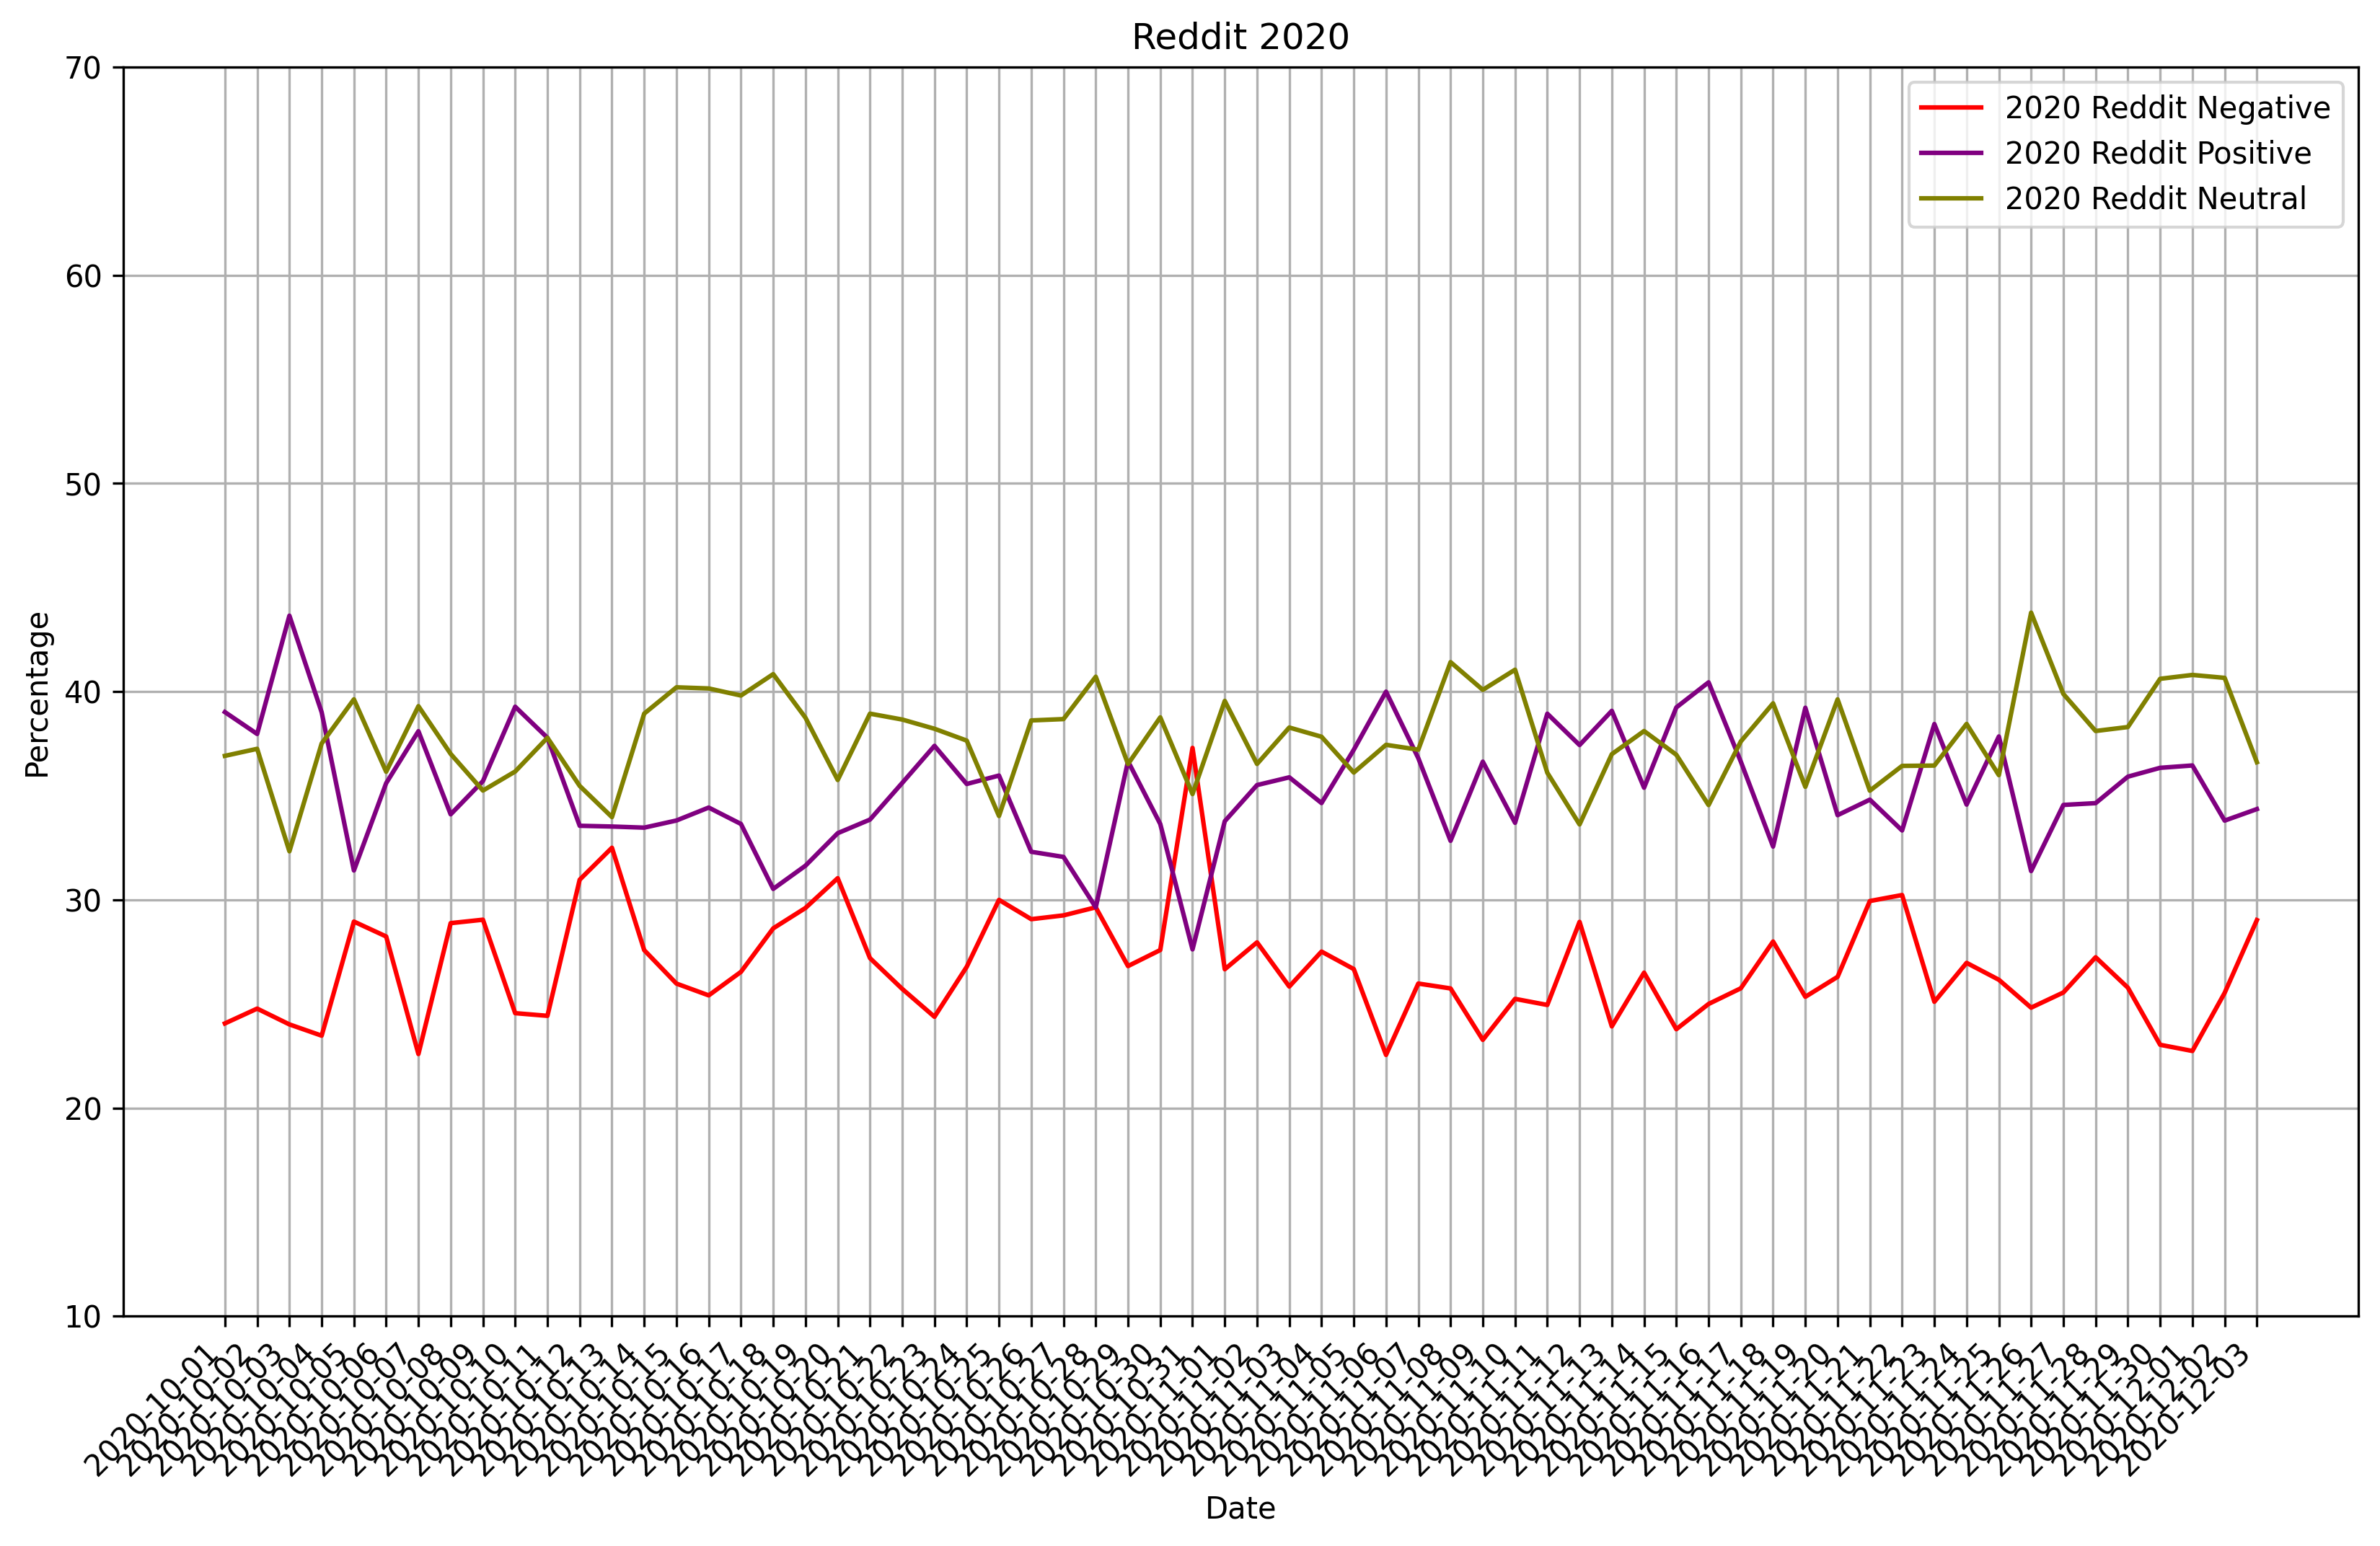

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13.33,7.5), dpi=300)

axes.plot(result_df_reddit_2020['Date_created'], result_df_reddit_2020['Negative %'],color='red', label='2020 Reddit Negative',linewidth=1.5)
axes.plot(result_df_reddit_2020['Date_created'], result_df_reddit_2020['Positive %'],color='purple', label='2020 Reddit Positive',linewidth=1.5)
axes.plot(result_df_reddit_2020['Date_created'], result_df_reddit_2020['Neutral %'],color='olive', label='2020 Reddit Neutral',linewidth=1.5)
axes.set_xlabel('Date')
axes.set_ylabel('Percentage')
axes.set_title('Reddit 2020')
axes.set_xticks(result_df_reddit_2020['Date_created'])
axes.set_xticklabels(result_df_reddit_2020['Date_created'],rotation=45, ha='right')
axes.set_yticks([10,20,30,40,50,60,70])
axes.set_yticklabels(['10','20','30','40','50','60','70'])
axes.grid()
axes.legend()

# Reddit 2021 Sentiment percentage overtime for each classification

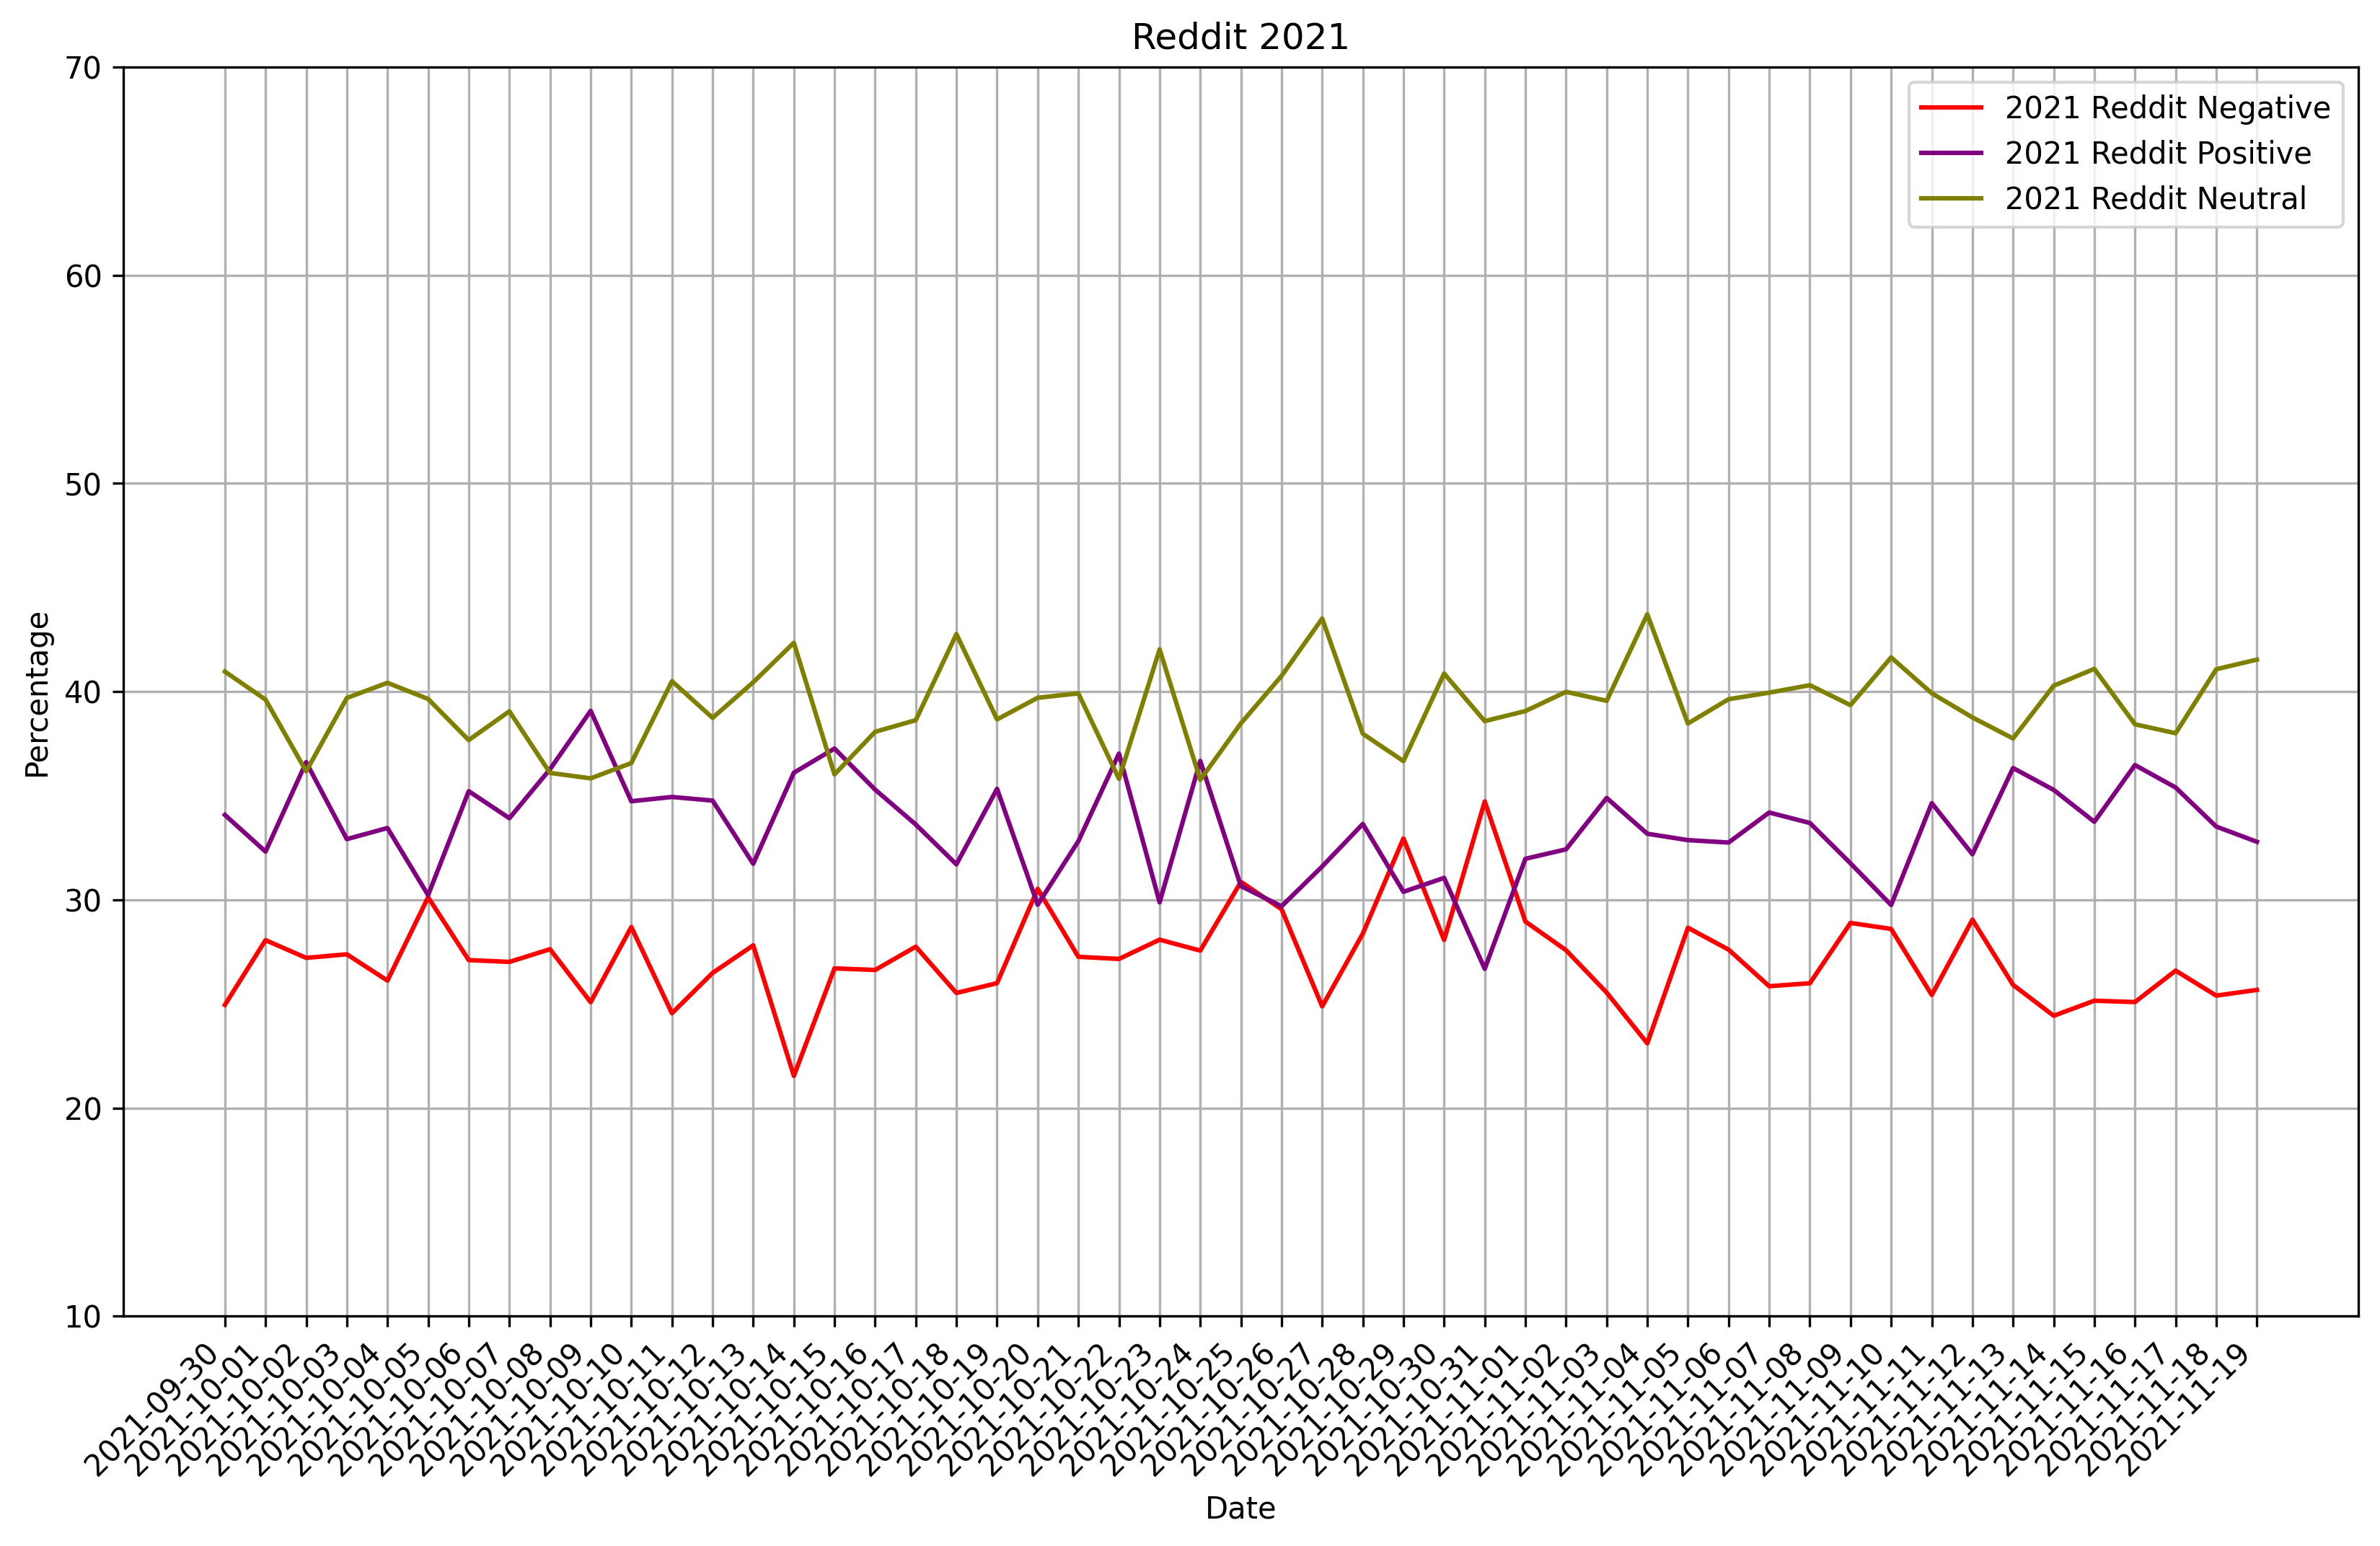

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13.33,7.5),dpi=300)
axes.plot(result_df_reddit_2021['Date_created'], result_df_reddit_2021['Negative %'],color='red', label='2021 Reddit Negative',linewidth=1.5)
axes.plot(result_df_reddit_2021['Date_created'], result_df_reddit_2021['Positive %'],color='purple', label='2021 Reddit Positive',linewidth=1.5)
axes.plot(result_df_reddit_2021['Date_created'], result_df_reddit_2021['Neutral %'],color='olive', label='2021 Reddit Neutral',linewidth=1.5)
axes.set_xlabel('Date')
axes.set_ylabel('Percentage')
axes.set_title('Reddit 2021')
axes.set_xticks(result_df_reddit_2021['Date_created'])
axes.set_xticklabels(result_df_reddit_2021['Date_created'],rotation=45, ha='right')
axes.set_yticks([10,20,30,40,50,60,70])
axes.set_yticklabels(['10','20','30','40','50','60','70'])
axes.grid()
axes.legend()

# Reddit 2022 Sentiment percentage overtime for each classification

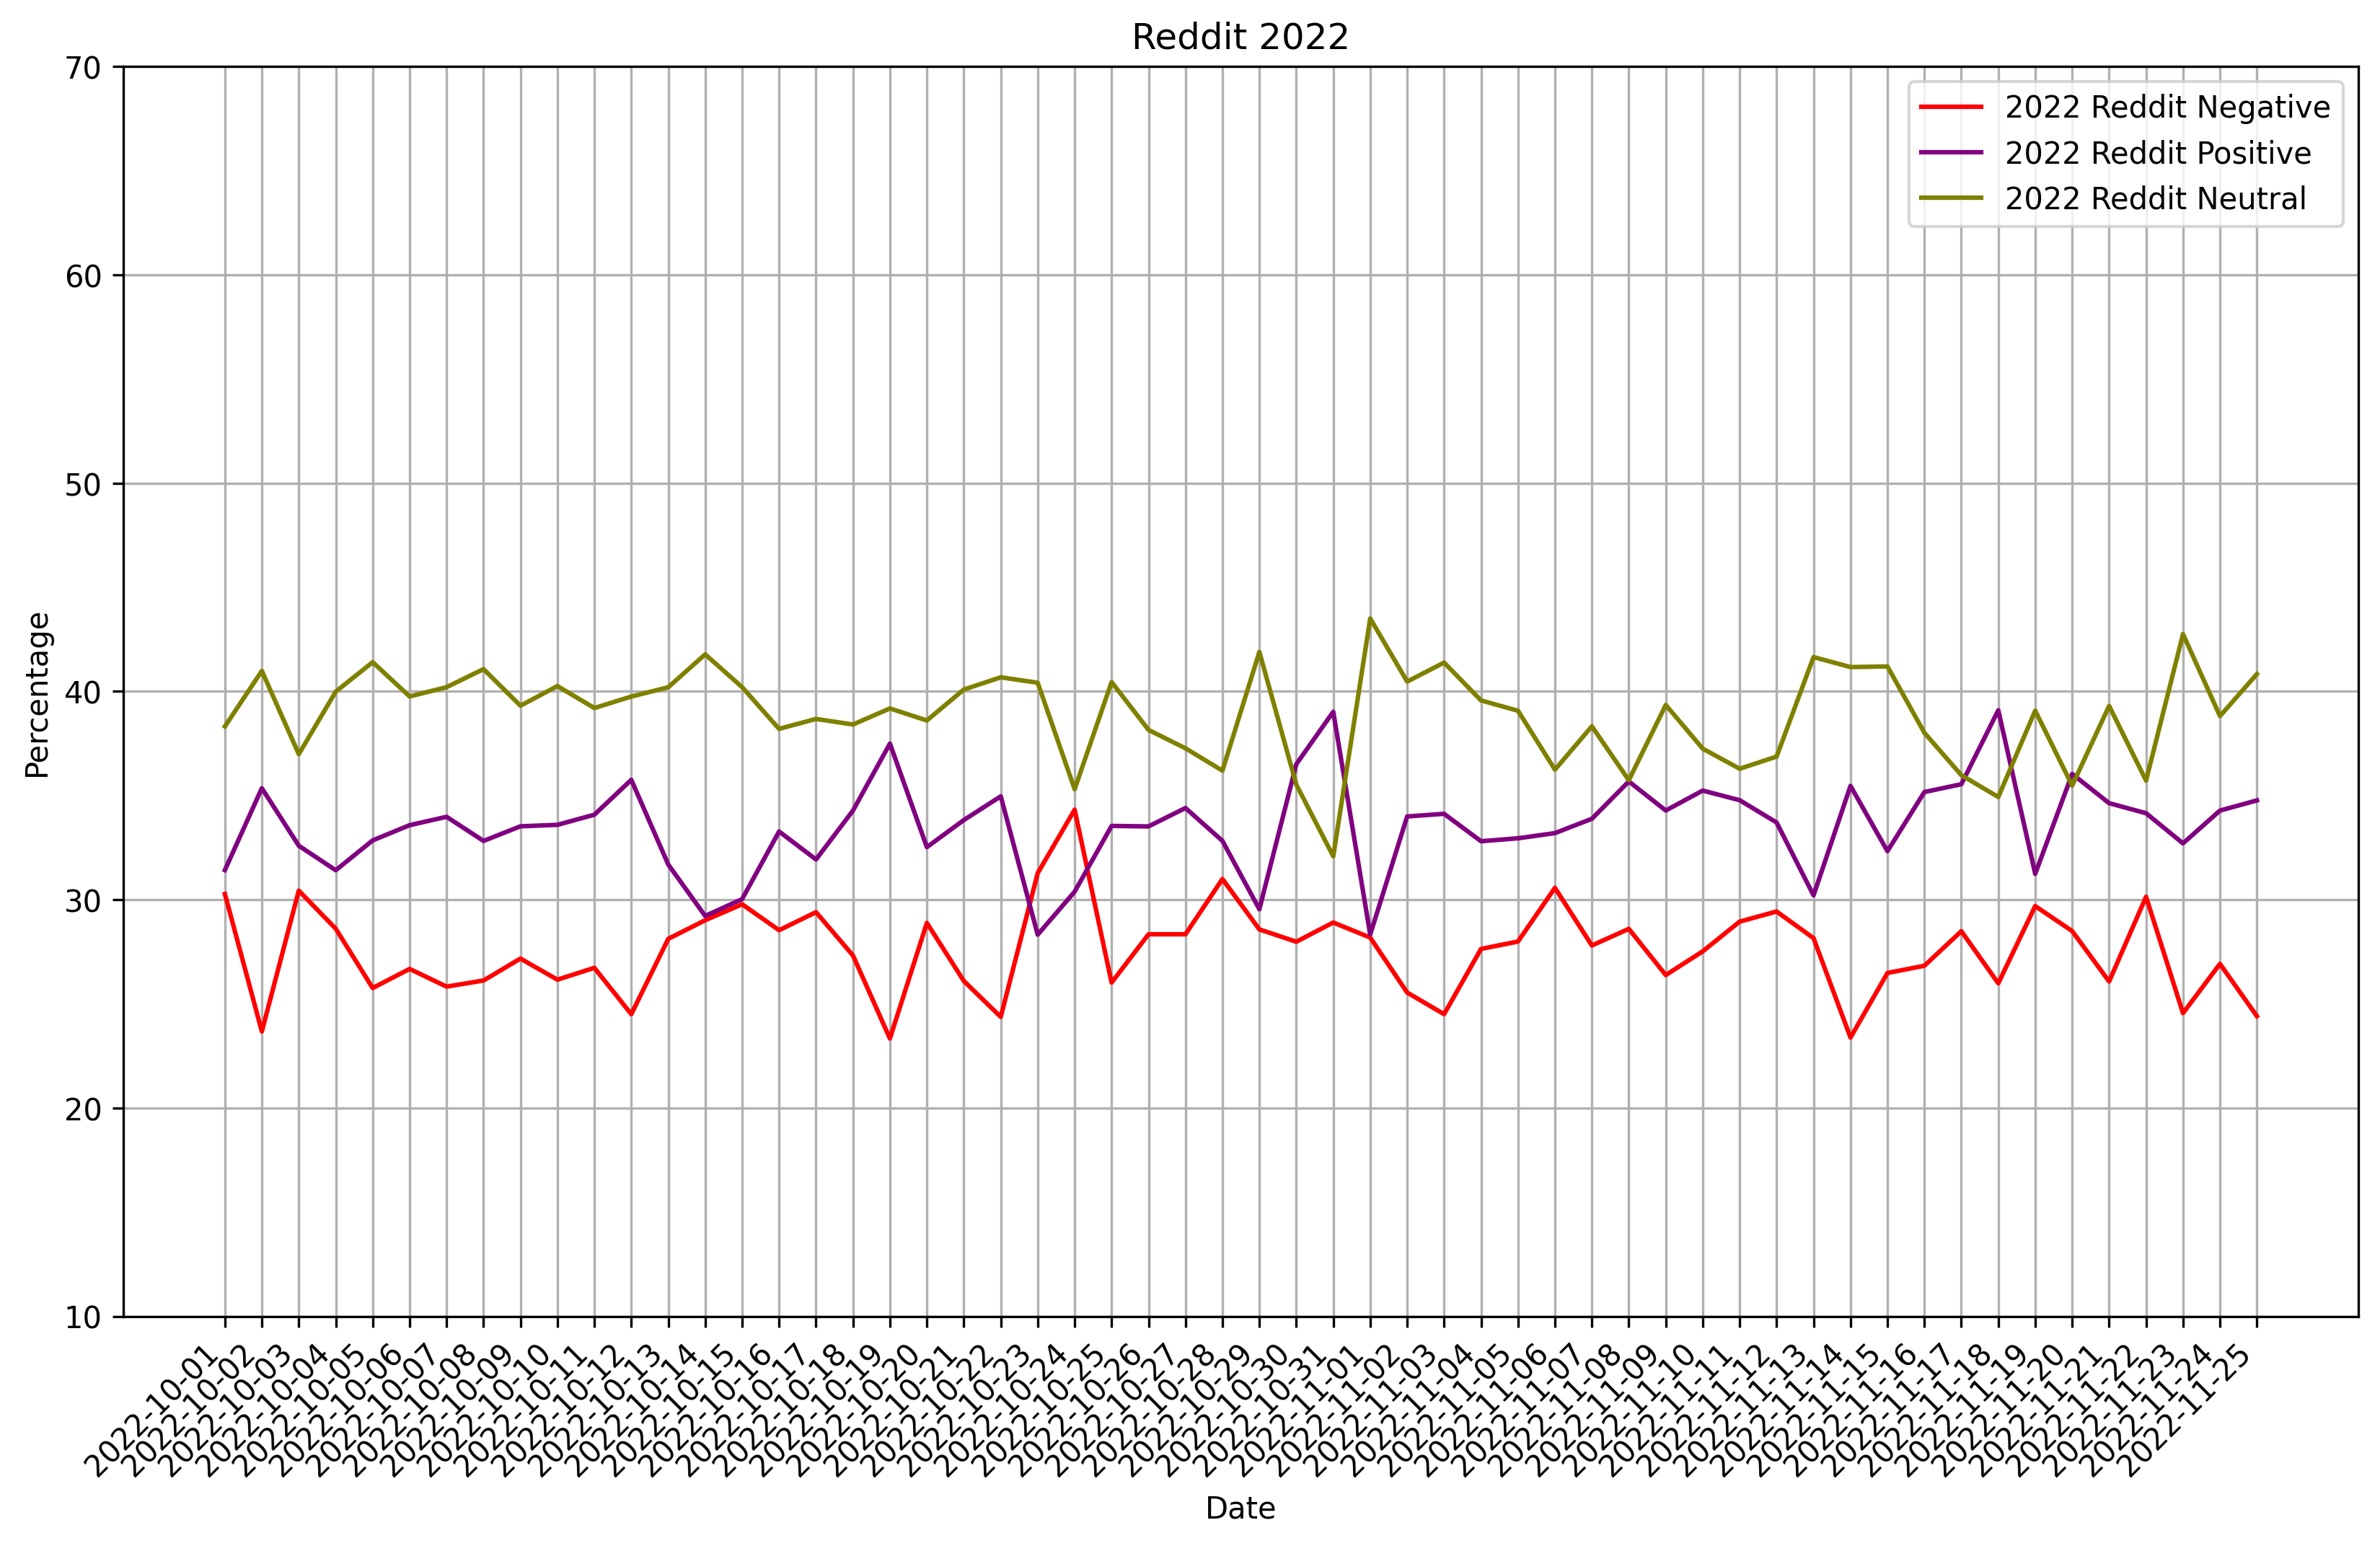

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13.33,7.5),dpi=300)

axes.plot(result_df_reddit_2022['Date_created'], result_df_reddit_2022['Negative %'],color='red', label='2022 Reddit Negative',linewidth=1.5)
axes.plot(result_df_reddit_2022['Date_created'], result_df_reddit_2022['Positive %'],color='purple', label='2022 Reddit Positive',linewidth=1.5)
axes.plot(result_df_reddit_2022['Date_created'], result_df_reddit_2022['Neutral %'],color='olive', label='2022 Reddit Neutral',linewidth=1.5)
axes.set_xlabel('Date')
axes.set_ylabel('Percentage')
axes.set_title('Reddit 2022')
axes.set_xticks(result_df_reddit_2022['Date_created'])
axes.set_xticklabels(result_df_reddit_2022['Date_created'],rotation=45, ha='right')
axes.set_yticks([10,20,30,40,50,60,70])
axes.set_yticklabels(['10','20','30','40','50','60','70'])
axes.grid()
axes.legend()

# Reddit 2016 Negative word cloud for 2020-10-29

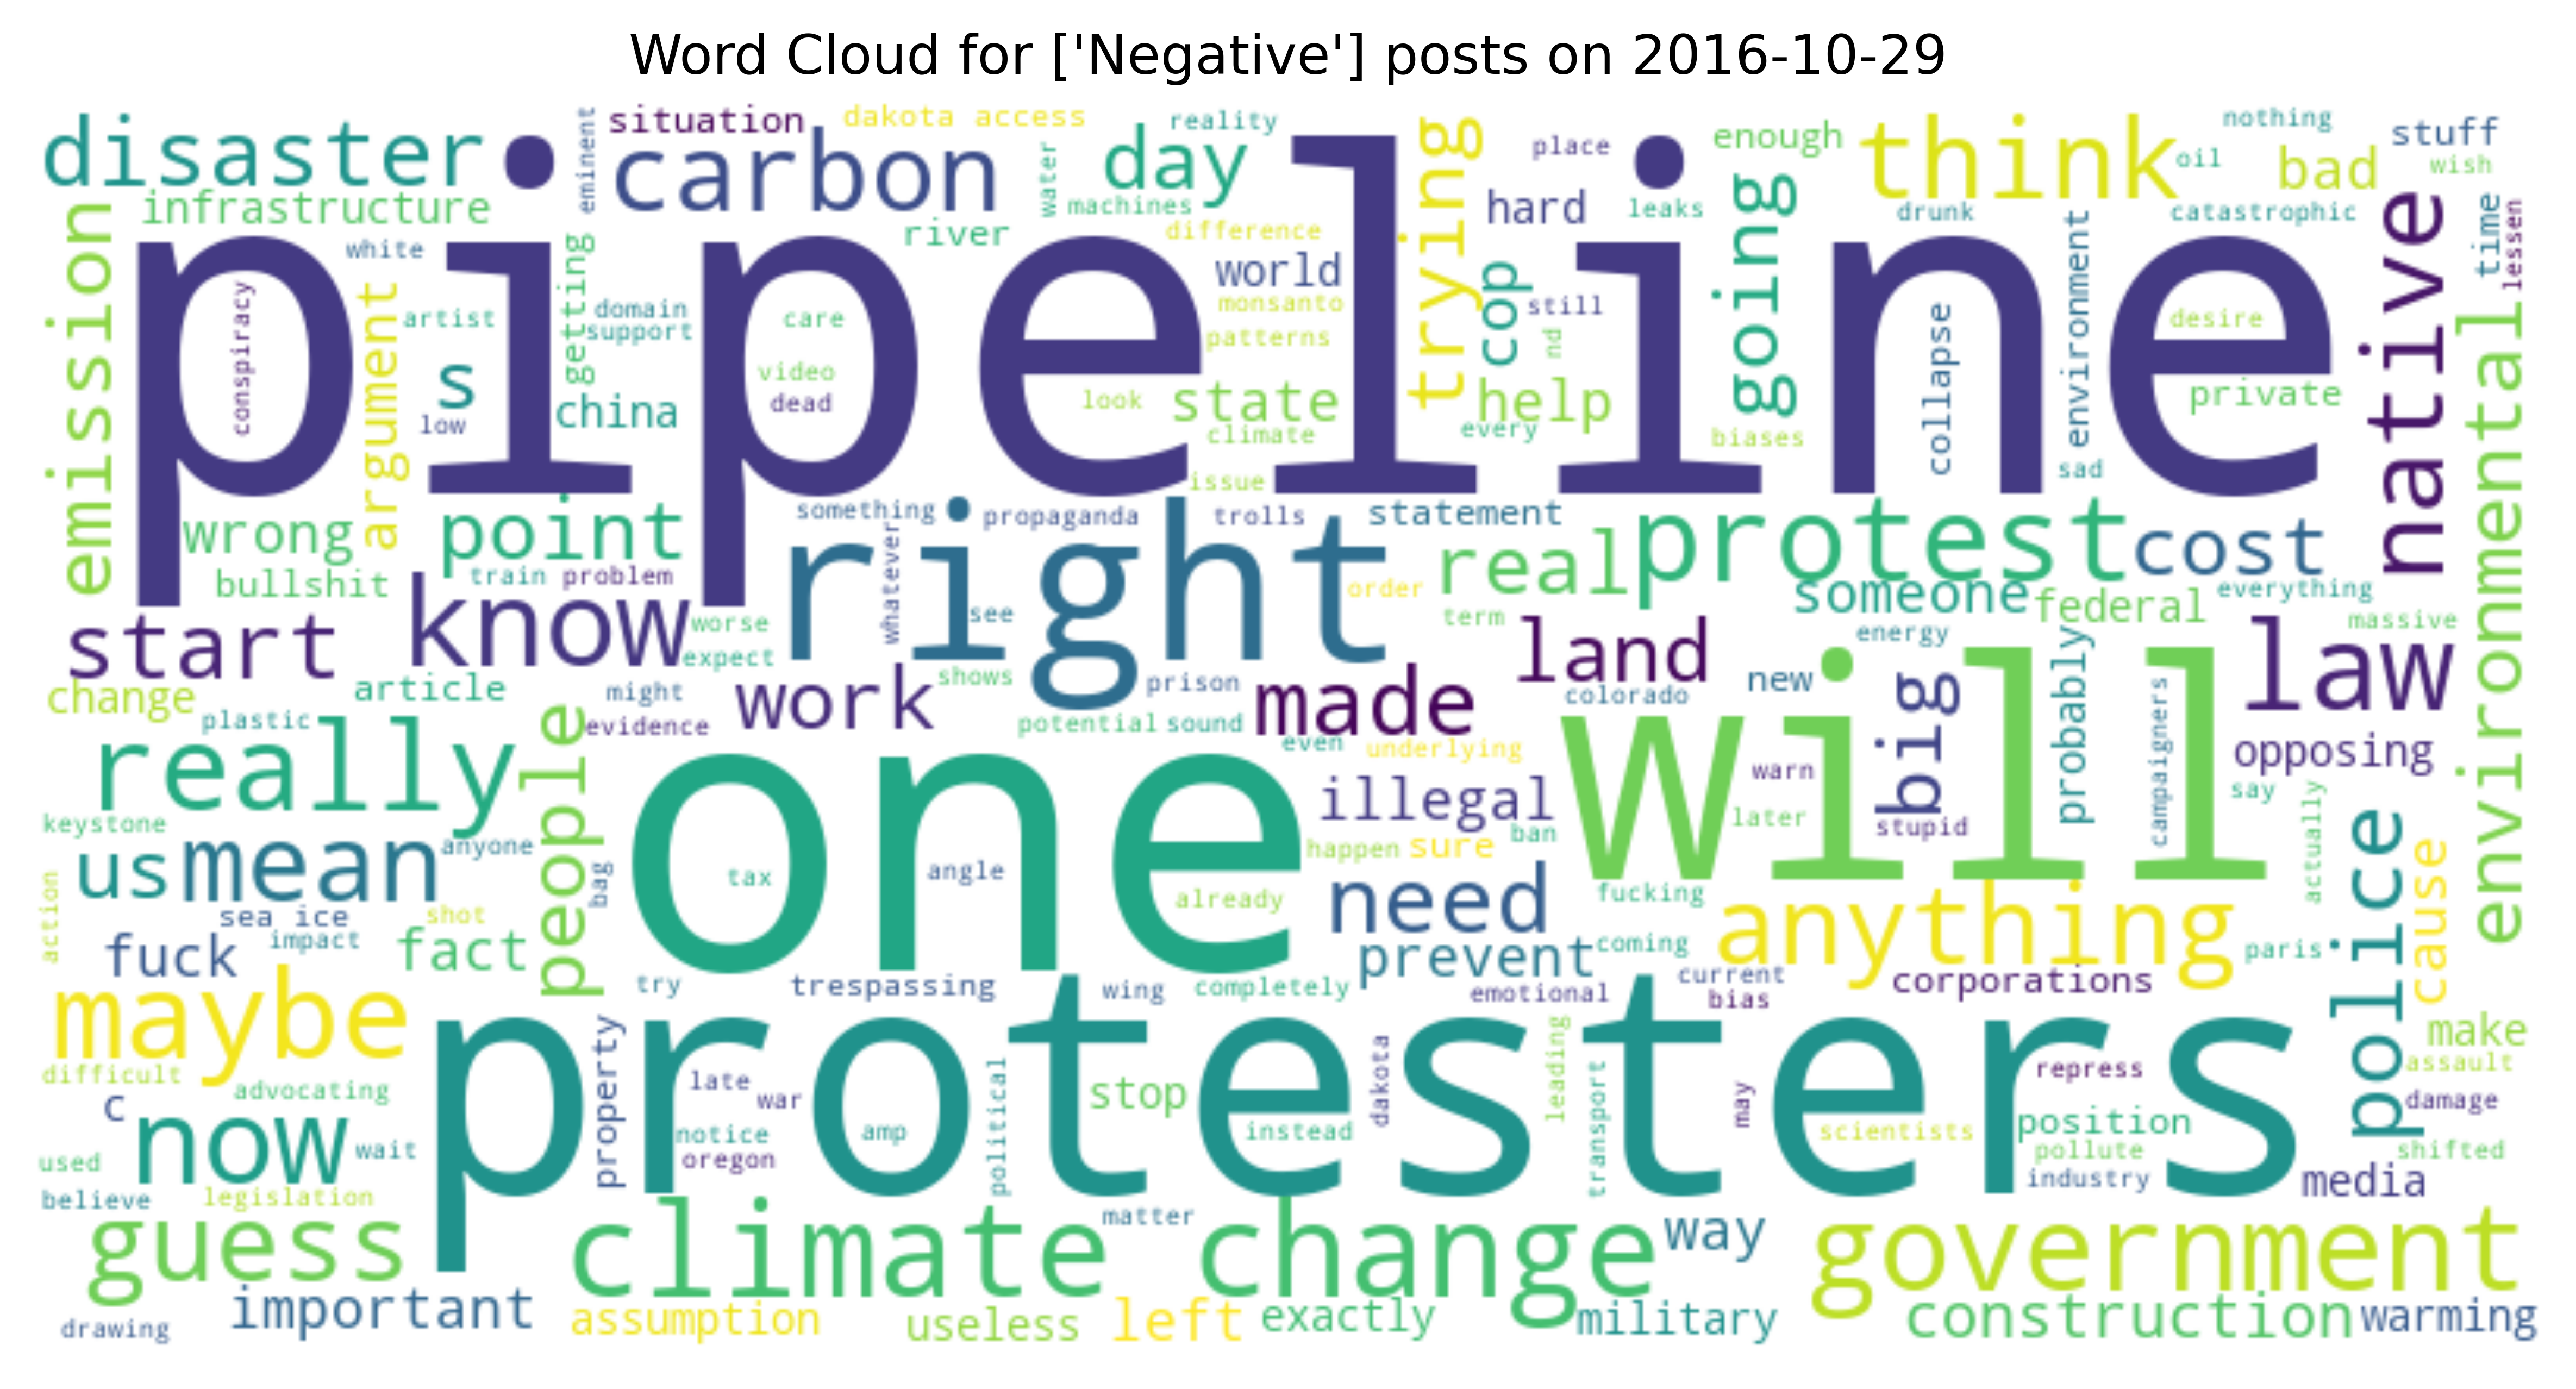

In [14]:
desired_date=["2016-10-29"]
desired_sentiment=["Negative"]
#['GlobalWarming', 'climate', 'climatechange', 'climatepolicy', 'environment', 'politics', 'sustainability', 'worldnews']
desired_subreddit=['GlobalWarming', 'climate', 'climatechange', 'climatepolicy', 'environment', 'politics', 'sustainability', 'worldnews']
generate_word_cloud(desired_date,reddit_2016,desired_sentiment,desired_subreddit)

# Code for experiments conducted in the sentiment  evaluation stage

In [ ]:
# Average Method.

def sentiment_analyzer_scores_average(article):
    analyser = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(article)

    sentiment_scores = []
    for sentence in sentences:
        score = analyser.polarity_scores(sentence)
        sentiment_scores.append(score)

    avg_sentiment = calculate_average_sentiment(sentiment_scores)
    compound_values=avg_sentiment['compound']
    if compound_values > 0.05:
            return ("Positive")
    elif compound_values < -0.05:
            return ("Negative")
    else:
            return ("Neutral")
    
    return avg_sentiment

def calculate_average_sentiment(sentiment_scores):
    num_sentences = len(sentiment_scores)
    total_sentiment = {
        'neg': 0,
        'neu': 0,
        'pos': 0,
        'compound': 0
    }

    for score in sentiment_scores:
        total_sentiment['neg'] += score['neg']
        total_sentiment['neu'] += score['neu']
        total_sentiment['pos'] += score['pos']
        total_sentiment['compound'] += score['compound']

    avg_sentiment = {
        'neg': total_sentiment['neg'] / num_sentences,
        'neu': total_sentiment['neu'] / num_sentences,
        'pos': total_sentiment['pos'] / num_sentences,
        'compound': total_sentiment['compound'] / num_sentences
    }

    return avg_sentiment

In [ ]:
#Intensity method.

def sentiment_analyzer_scores_intensity(text):
    sentences = sent_tokenize(text)  # Tokenize at the sentence level
    tokenized_sentences = []
    
    # Tokenize sentences and remove stopwords
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        filtered_tokens = [token for token in tokens if token.lower()]
        tokenized_sentences.append(filtered_tokens)
    analyzer=SentimentIntensityAnalyzer()
    scores=[]
    for tokens in tokenized_sentences:
        sentence = ' '.join(tokens)
        score = analyzer.polarity_scores(sentence)
        scores.append(score)
    compound_values = []
    for item in scores:
            compound_values.append(item['compound'])
    #Scoring based on intensity
    positive_sum = 0.0
    negative_sum = 0.0
    neutral_sum = 0.0
    pos,neg,neu=0,0,0

    for compound in compound_values:
        if compound > 0.05:
            positive_sum += compound
            pos += 1
        elif compound < -0.05:
            negative_sum += compound
            neg +=1
        else:
            neutral_sum += compound
            neu +=1
            
    tot =pos+neg+neu
    p=(positive_sum*pos)/tot
    n=(negative_sum*neg)/tot
    ne=(neutral_sum*neu)/tot
    

    if (abs(p) > abs(n)) and (abs(p) > abs(ne)):
        return ("Positive")
   # #sentiment_intensity = abs(positive_sum) - neutral_sum
    elif (abs(n) > abs(p)) and (abs(n) > abs(ne)) :
        return ("Negative")
    #sentiment_intensity = abs(negative_sum) - neutral_sum
    elif (abs(ne) > abs(p)) and (abs(ne) > abs(n)):
        return ("Neutral")
    #sentiment_intensity = 0.0  